# Задача 5. Обучение без учителя

* **Дедлайн**: 14.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

-  Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
-  Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
-  Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
-  Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
-  При обучении использовать **подбор гиперпараметров**.
-  Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Imports

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
import re
import optuna

from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.metrics import davies_bouldin_score, rand_score, calinski_harabasz_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, ClusterMixin

## Датасет

### FIFA 21 Complete Player Information

**Context**
Football Analysis

**Content**
Detailed attributes for every player registered in the latest edition of the FIFA 21 database.
Scraping code at GitHub repo: https://github.com/4m4n5/fifa18-all-player-statistics/tree/master/2021

**Acknowledgements**
Data scraped from https://sofifa.com/

**Inspiration**
Inspired from: https://www.kaggle.com/karangadiya/fifa19 and https://www.kaggle.com/lykin22/fifa19-player-team-analysis-and-value-predict

**Link**

https://www.kaggle.com/datasets/umeshkumar017/fifa-21-player-and-formation-analysis

## EDA

In [318]:
df = pd.read_csv(filepath_or_buffer=kagglehub.dataset_download("umeshkumar017/fifa-21-player-and-formation-analysis") + "/fifa21.csv")
df.head()


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Penalties,Composure,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
0,0,253283,Facundo Pellistri,18,https://cdn.sofifa.com/players/253/283/20_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,71,87,Peñarol,...,66.0,61.0,35.0,11.0,18.0,9.0,12.0,7.0,8.0,7.0
1,1,179813,Edinson Cavani,32,https://cdn.sofifa.com/players/179/813/20_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,86,86,Paris Saint-Germain,...,85.0,80.0,57.0,48.0,39.0,12.0,5.0,13.0,13.0,10.0
2,2,245541,Giovanni Reyna,17,https://cdn.sofifa.com/players/245/541/20_60.png,United States,https://cdn.sofifa.com/flags/us.png,68,87,Borussia Dortmund,...,50.0,59.0,30.0,23.0,24.0,10.0,13.0,14.0,12.0,7.0
3,3,233419,Raphael Dias Belloli,23,https://cdn.sofifa.com/players/233/419/20_60.png,Brazil,https://cdn.sofifa.com/flags/br.png,81,85,Stade Rennais FC,...,73.0,79.0,45.0,54.0,38.0,8.0,7.0,13.0,8.0,14.0
4,4,198710,James Rodríguez,28,https://cdn.sofifa.com/players/198/710/20_60.png,Colombia,https://cdn.sofifa.com/flags/co.png,82,82,Everton,...,81.0,87.0,52.0,41.0,44.0,15.0,15.0,15.0,5.0,14.0


Удалим фото, флаг и лого клуба, т.к. они представлены ссылками. Также удалим unnamed представляющий индексацию. А также оценку "силы" на разных позициях, так как они выражаются какой-то непонятной мне, как неиграющему в фифу суммой, которая не может быть выражена, как число, а я не уверен насколько корректно будет действительно их сложить

In [319]:
df = df.drop(['Photo', 'Flag', 'Club Logo', 'Unnamed: 0', 'Joined'], axis=1)
df = df.drop(columns=["LS", "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM", "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB", "CB", "RCB", "RB", "GK"])

Переведем некоторые object представления в корректные числа

In [320]:
def height_to_cm(h):
    match = re.match(r"(\d+)'(\d+)", h)
    if match:
        feet, inches = match.groups()
        total_inches = int(feet) * 12 + int(inches)
        cm = round(total_inches * 2.54, 1)
        return cm
    return None

def weight_to_kg(w):
    match = re.match(r"(\d+)lbs", w)
    if match:
        lbs = int(match.group(1))
        kg = round(lbs * 0.45359237, 1)
        return kg
    return None

df['Body Type'] = df['Body Type'].str.replace(r'\s*\(.*\)', '', regex=True)
df['Height_cm'] = df['Height'].apply(height_to_cm)
df['Weight9_kg'] = df['Weight'].apply(weight_to_kg)

df = df.drop(columns=['Height', 'Weight'])

In [321]:
df.describe()

,ID,Age,Overall,Potential,Value,Wage,Special,Release Clause,Jersey Number,Likes,...,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Height_cm,Weight9_kg
count,18541.000000,18541.000000,18541.000000,18541.000000,1.854100e+04,18541.000000,18541.000000,1.649600e+04,18516.000000,18541.000000,...,16849.000000,18411.000000,18370.000000,18511.000000,18509.000000,18509.000000,18507.000000,18505.000000,18541.000000,18541.000000
mean,218813.779731,25.322636,66.723586,72.187153,2.420461e+06,10088.064290,1624.428618,4.824023e+06,20.452095,10.879564,...,47.070687,47.971430,45.847904,15.672087,15.566643,15.552596,15.565246,15.802864,181.241627,75.163675
std,38144.535736,4.954431,6.861342,5.786598,5.166395e+06,20474.923541,261.787379,1.041590e+07,16.943162,38.096726,...,20.099168,21.486975,21.175411,16.863310,16.177023,16.039980,16.401177,17.134275,6.852344,7.145040
min,2.000000,16.000000,38.000000,46.000000,0.000000e+00,0.000000,731.000000,5.000000e+03,1.000000,0.000000,...,3.000000,5.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,154.900000,49.900000
25%,203431.000000,21.000000,62.000000,68.000000,3.500000e+05,1000.000000,1486.000000,6.770000e+05,9.000000,0.000000,...,30.000000,28.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,175.300000,69.900000
50%,228658.000000,25.000000,67.000000,72.000000,7.500000e+05,3000.000000,1654.000000,1.400000e+06,17.000000,1.000000,...,52.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000,180.300000,74.800000
75%,243894.000000,29.000000,71.000000,76.000000,2.200000e+06,10000.000000,1805.000000,4.200000e+06,27.000000,6.000000,...,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000,185.400000,79.800000
max,259105.000000,53.000000,93.000000,95.000000,1.055000e+08,560000.000000,2316.000000,2.031000e+08,99.000000,1106.000000,...,94.000000,93.000000,95.000000,90.000000,92.000000,93.000000,93.000000,90.000000,205.700000,110.200000


In [322]:
[print(col) for col in df if df[col].isna().sum() > 0]

Club
Body Type
Real Face
Release Clause
Position
Jersey Number
Contract Valid Until
Crossing
Finishing
Heading Accuracy
Short Passing
Volleys
Dribbling
Curve
FK Accuracy
Long Passing
Ball Control
Acceleration
Sprint Speed
Agility
Reactions
Balance
Shot Power
Jumping
Stamina
Strength
Long Shots
Aggression
Interceptions
Positioning
Vision
Penalties
Composure
Defensive Awareness
Standing Tackle
Sliding Tackle
GK Diving
GK Handling
GK Kicking
GK Positioning
GK Reflexes


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Заполним все численные null значения медианой. Строки где есть null в колонке с типом object удалим

Для начала проверим, что удаление не уберет много строк

In [323]:
len(df)

18541

In [324]:
float_cols = df.select_dtypes(include=['float64', 'int64']).columns
ndata = df.copy()
for col in float_cols:
    ndata.fillna({col: df[col].median()}, inplace=True)

df = df.dropna()
[print(col) for col in df if df[col].isna().sum() > 0]

[]

In [325]:
len(df)

15191

Потеря около 25% это много, но так как я и так собирался резать датасет, чтобы при обучении не пришлось кэшировать данные

In [326]:
df = df[:4000]

In [327]:
df.duplicated().sum()

np.int64(0)

Дупликатов нет

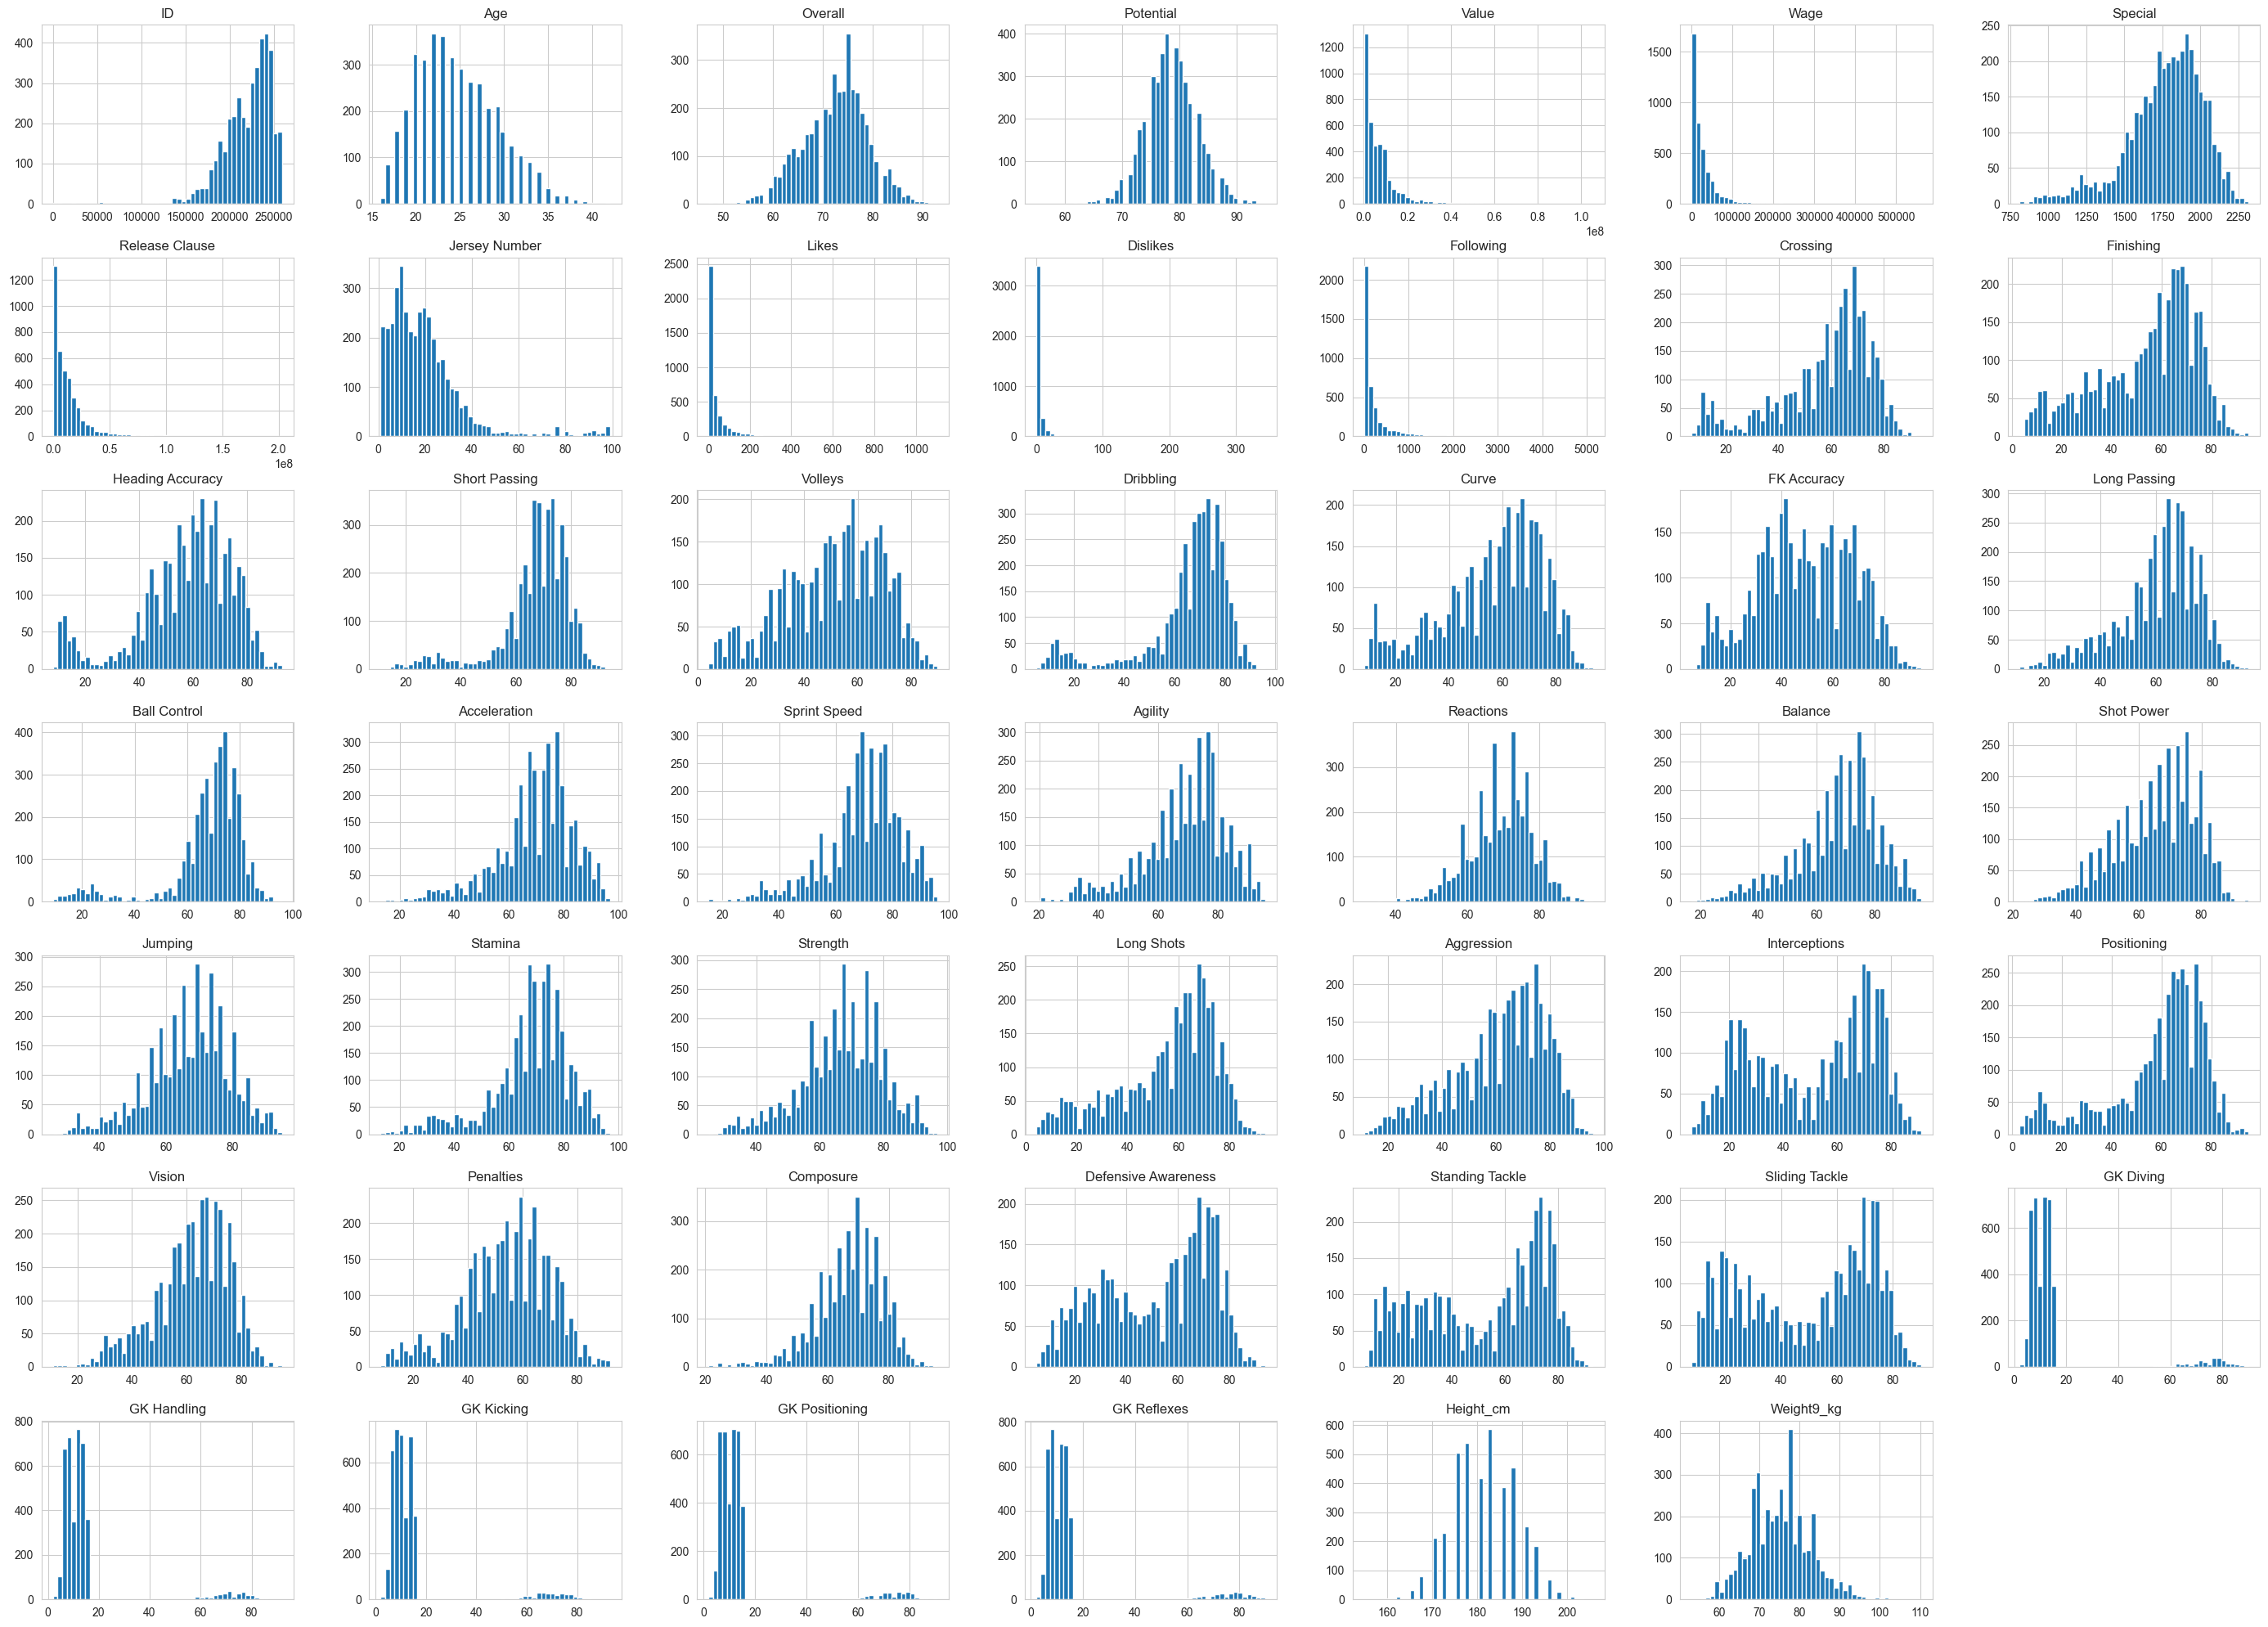

In [328]:
df.hist(figsize = (35,25), bins = 50)
plt.show()

Закодируем текстовые типы и применим пару эвристик для выбора оптимального кол-ва кластеров

In [329]:
encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

Построим матрицу отношений, чтобы удалить сильно связанные признаки

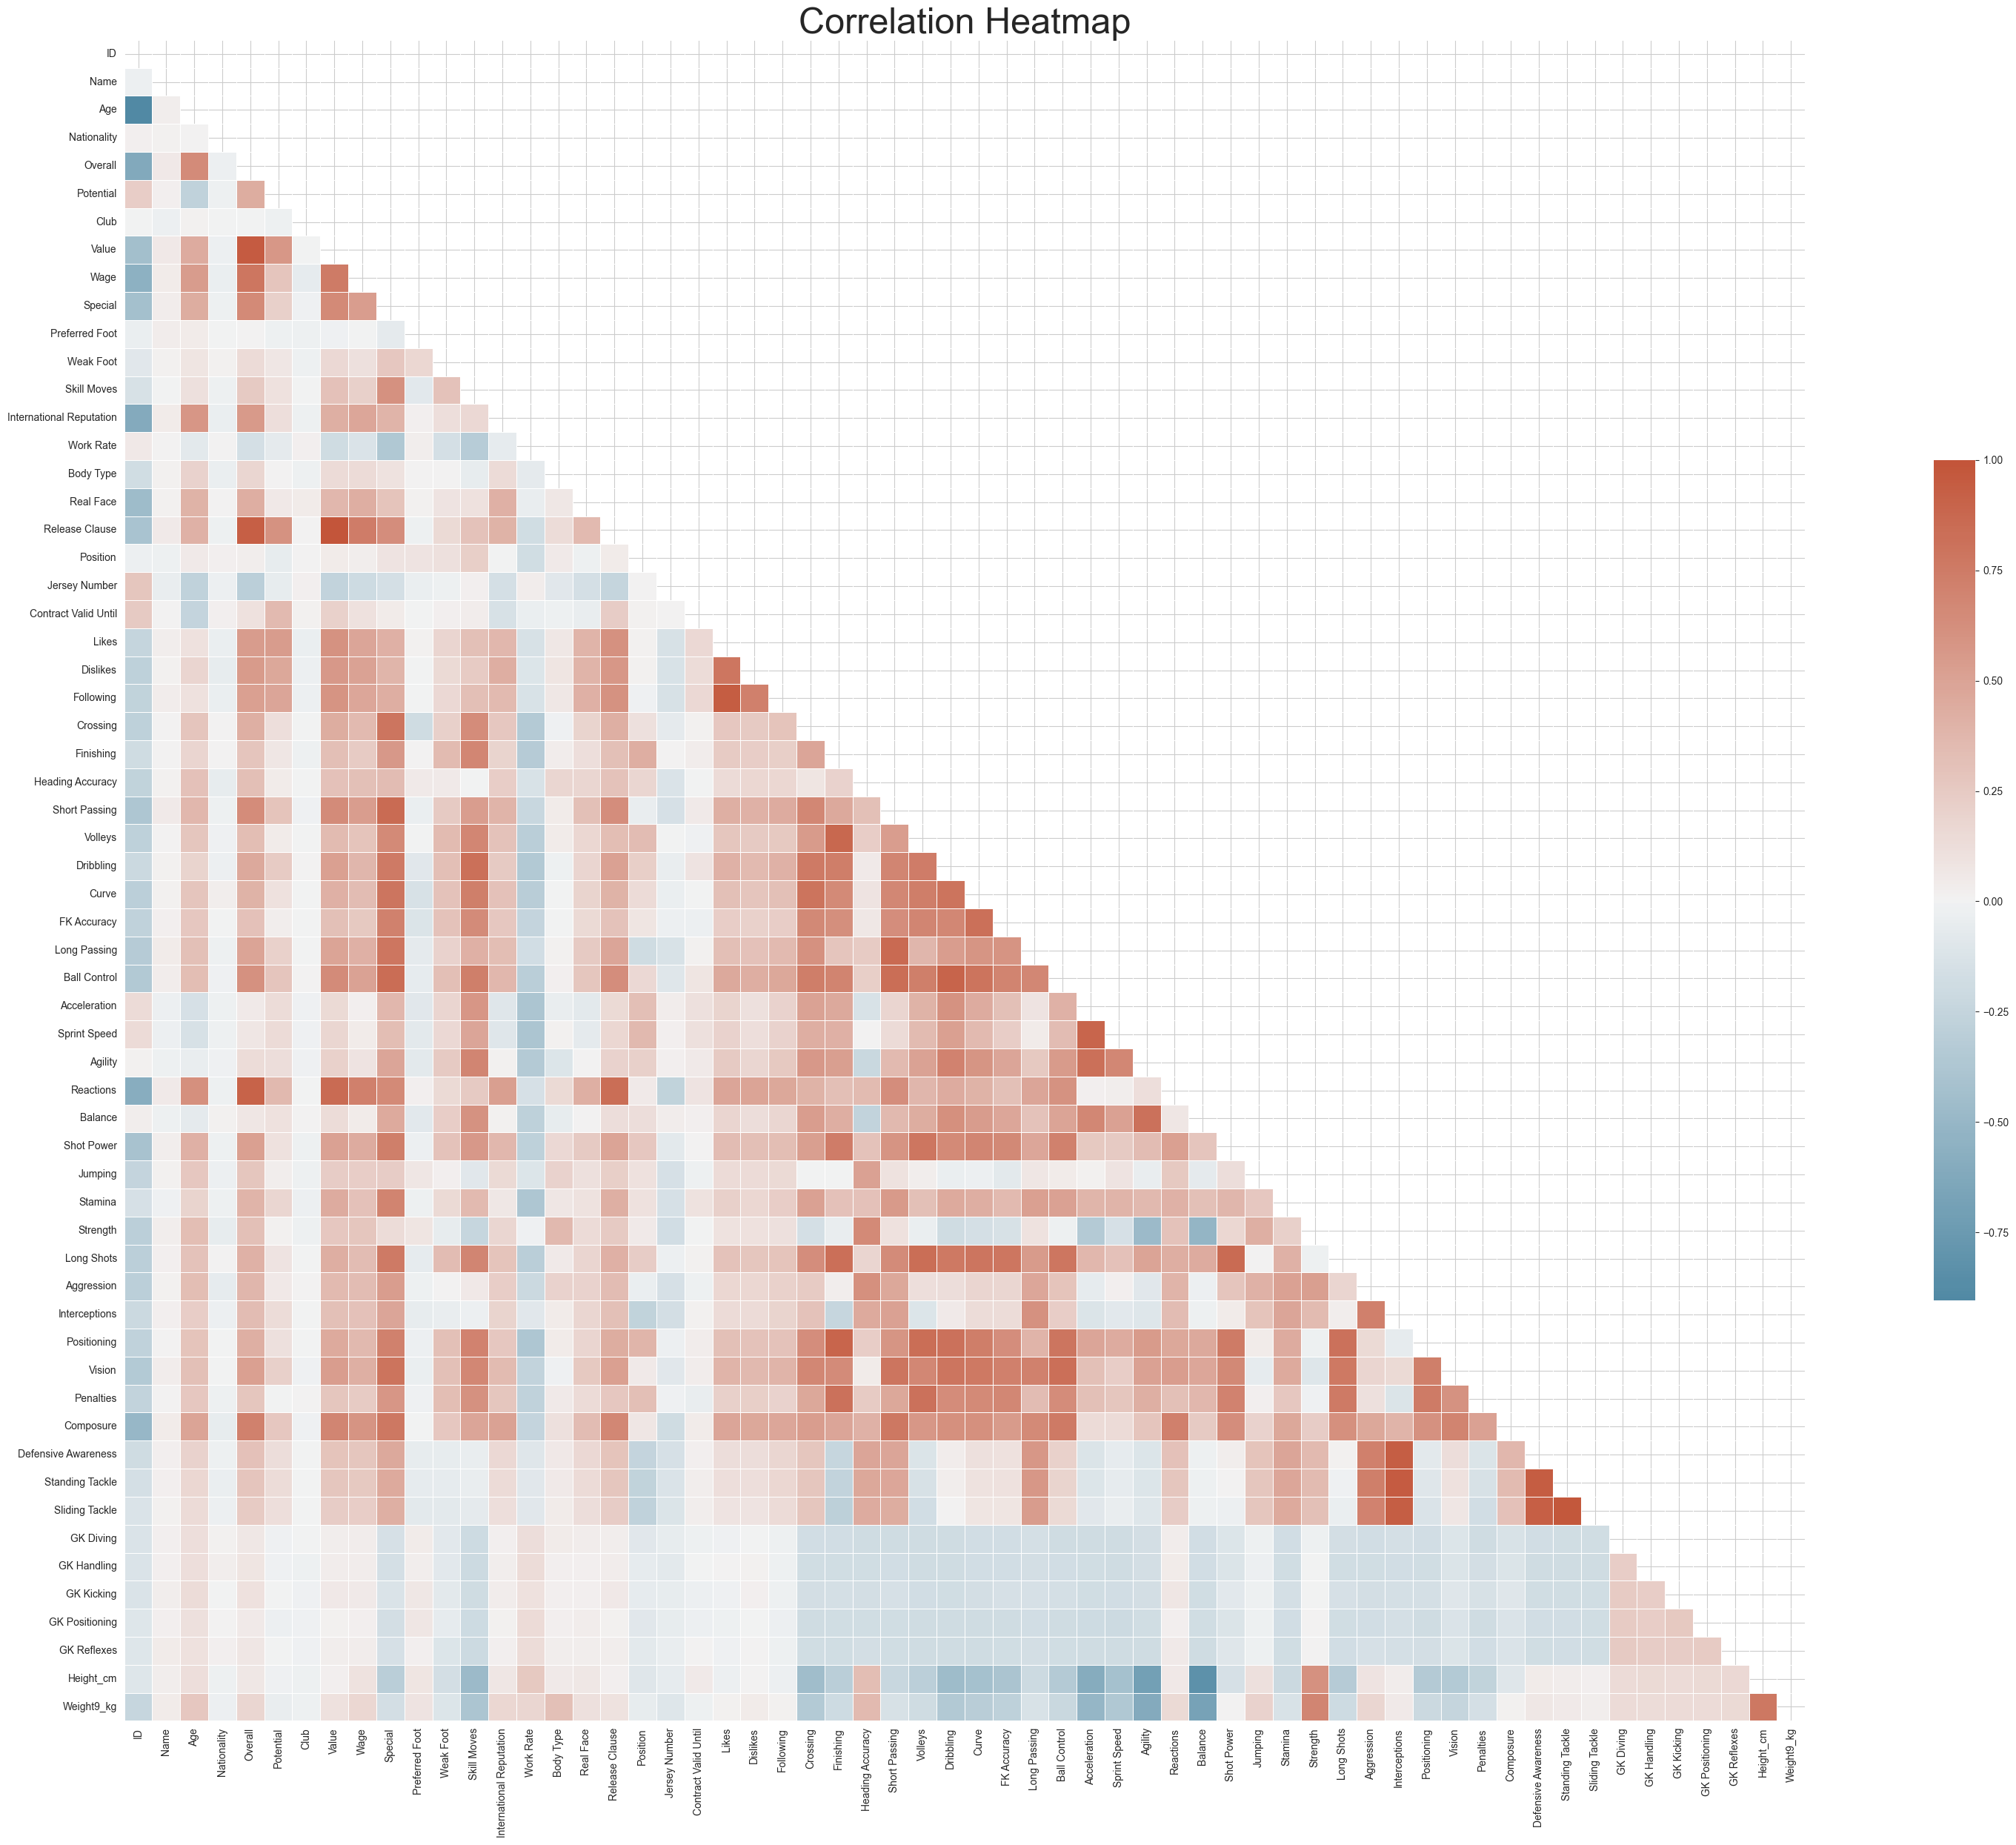

In [330]:
f,ax = plt.subplots(figsize=(35, 25))

mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat,dtype=bool))
cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(mat,mask=mask,cmap=cmap,vmax=1,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

plt.title('Correlation Heatmap',fontsize=35)

plt.tight_layout()

plt.show()

Удалим 7 признаков, которые наиболее связны с другими признаками, чтобы признаков было как раз 50

In [331]:
from collections import defaultdict
import heapq

y = df["Name"]
X = df.drop(["Name"], axis=1)
list_int = []

correlation_frequency = defaultdict(int)

for col1 in X:
    list_int.append(col1)
    for col2 in X:
        if col2 not in list_int:
            R_corr = df.corr().loc[col1,col2]
            if R_corr > 0.9 or R_corr < -0.9:
                 correlation_frequency[col1] += 1
                 correlation_frequency[col2] += 1

top_keys = heapq.nlargest(7, correlation_frequency, key=correlation_frequency.get)
df = df.drop(columns=top_keys)

In [332]:
len(df.head().columns)

53

In [333]:
y = df["Name"]
X = df.drop(["Name"], axis=1)


### Метод локтя

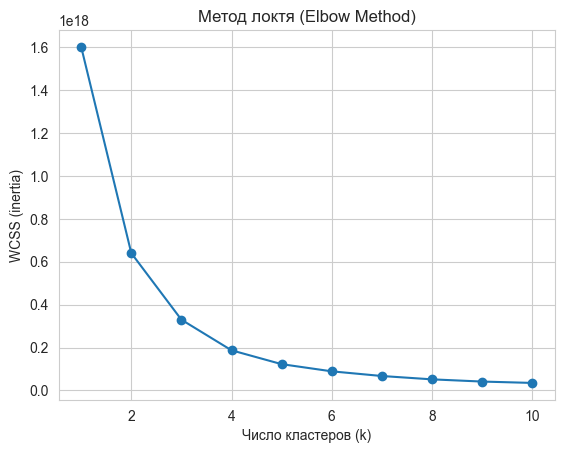

In [334]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1337, n_init=10).fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('WCSS (inertia)')
plt.title('Метод локтя (Elbow Method)')
plt.show()

Из графика видно что, согласно данной эвристике, оптимальным числом кластеров может быть 2, 3, 4, 5, 6, 7, 8

### Коэффициент Дэвиса–Булдина

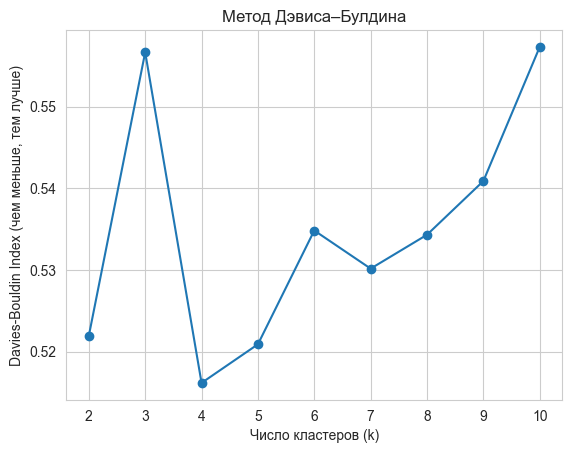

In [335]:
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1337, n_init=10).fit(X)
    score = davies_bouldin_score(X, kmeans.labels_)
    scores.append(score)

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Davies-Bouldin Index (чем меньше, тем лучше)')
plt.title('Метод Дэвиса–Булдина')
plt.show()

Коэффициент Дэвиса–Булдина сильно выделяет 4. Возьмем 4 за основу

## PCA

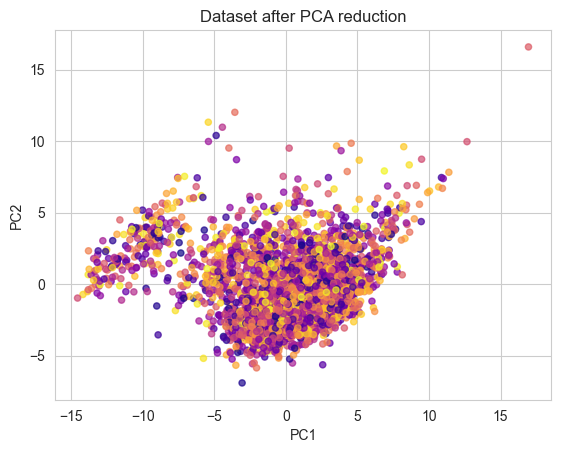

In [336]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)  # <-- исправлено
X_test_pca = pca.transform(X_test_scaled)        # <-- исправлено

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, alpha=0.7, s=20, cmap=plt.get_cmap('plasma'))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset after PCA reduction')
plt.show()

## t-SNE

In [ ]:
tsne = TSNE(random_state=1337)
tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(35, 25))
plt.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c=y_train,
    alpha=0.7,
    s=20,
    cmap=plt.get_cmap('plasma'),
)
plt.colorbar()
plt.title("Dataset after t-SNE reduction")

## Реализация KMeans

In [311]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=4, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, targets = None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        np.random.seed(42)
        random_idxs = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_idxs]

        for i in range(self.max_iter):
            clusters = self._assign_clusters(X)
            new_centroids = np.array([X[clusters == j].mean(axis=0) for j in range(self.n_clusters)])
            if np.linalg.norm(self.centroids - new_centroids) < self.tol:
                break
            self.centroids = new_centroids
        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return self._assign_clusters(X)

    def _assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

## Подбор параметра


In [312]:
def run_test(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)
    return study.best_params

def create_objective(model_class, fixed_params, param_suggestions):
    def objective(trial):
        params = {**fixed_params, **{k: v(trial, k) for k, v in param_suggestions.items()}}
        model = model_class(**params)
        cv = KFold(n_splits=5, shuffle=True)
        cross_val = cross_val_score(model, X, y, scoring="rand_score", cv=cv, n_jobs=-1)
        return cross_val.mean()
    return objective


### MyKMeans

In [313]:
obj_MyKMeans = create_objective(MyKMeans, {"n_clusters": 4, "tol": 0.01}, {"max_iter": lambda t, k: t.suggest_categorical(k, [100 * i for i in range(1, 10)])})
best_MyKMeans_params =  run_test(obj_MyKMeans)
print("Best parameters for MyKMeans:", best_MyKMeans_params)

[I 2025-03-20 01:06:24,103] A new study created in memory with name: no-name-8233d28c-c3b0-43e2-abe7-09dd18591a7b
[I 2025-03-20 01:06:26,975] Trial 0 finished with value: 0.680886733416771 and parameters: {'max_iter': 100}. Best is trial 0 with value: 0.680886733416771.
[I 2025-03-20 01:06:28,550] Trial 1 finished with value: 0.6823335419274092 and parameters: {'max_iter': 800}. Best is trial 1 with value: 0.6823335419274092.
[I 2025-03-20 01:06:30,725] Trial 2 finished with value: 0.6539480600750938 and parameters: {'max_iter': 200}. Best is trial 1 with value: 0.6823335419274092.
[I 2025-03-20 01:06:32,015] Trial 3 finished with value: 0.6683767209011264 and parameters: {'max_iter': 200}. Best is trial 1 with value: 0.6823335419274092.
[I 2025-03-20 01:06:32,370] Trial 4 finished with value: 0.6656576971214018 and parameters: {'max_iter': 100}. Best is trial 1 with value: 0.6823335419274092.
[I 2025-03-20 01:06:32,696] Trial 5 finished with value: 0.6790450563204005 and parameters: {

Best parameters for MyKMeans: {'max_iter': 500}


### KMeans

In [314]:
obj_KMeans = create_objective(KMeans, {"n_clusters": 4, "random_state": 1337, "tol": 0.01}, {
    "max_iter": lambda t, k: t.suggest_categorical(k, [100 * i  for i in range(1, 10)]),
    "init": lambda t, k: t.suggest_categorical(k, ['random', 'k-means++'])
})
best_KMeans_params =  run_test(obj_KMeans)
print("Best parameters for KMeans:", best_KMeans_params)

[I 2025-03-20 01:06:37,848] A new study created in memory with name: no-name-24c5ad42-a1dc-4b09-88e0-6c199df26890
[I 2025-03-20 01:06:38,161] Trial 0 finished with value: 0.6565106382978724 and parameters: {'max_iter': 500, 'init': 'k-means++'}. Best is trial 0 with value: 0.6565106382978724.
[I 2025-03-20 01:06:38,480] Trial 1 finished with value: 0.6668873591989988 and parameters: {'max_iter': 800, 'init': 'k-means++'}. Best is trial 1 with value: 0.6668873591989988.
[I 2025-03-20 01:06:38,857] Trial 2 finished with value: 0.6970294117647058 and parameters: {'max_iter': 200, 'init': 'random'}. Best is trial 2 with value: 0.6970294117647058.
[I 2025-03-20 01:06:39,176] Trial 3 finished with value: 0.6937384230287859 and parameters: {'max_iter': 600, 'init': 'random'}. Best is trial 2 with value: 0.6970294117647058.
[I 2025-03-20 01:06:39,355] Trial 4 finished with value: 0.6949399249061325 and parameters: {'max_iter': 800, 'init': 'random'}. Best is trial 2 with value: 0.6970294117647

Best parameters for KMeans: {'max_iter': 200, 'init': 'random'}


### Affinity

In [315]:
obj_Affinity = create_objective(AffinityPropagation, {"random_state": 1337}, {
    "damping": lambda t, k: t.suggest_float(k, 0.5, 0.9, step=0.1),
    "max_iter": lambda t, k: t.suggest_categorical(k, [100 * i  for i in range(1, 10)]),
    "convergence_iter": lambda t, k: t.suggest_int(k, 10, 100, step=9)
})
best_Affinity_params = run_test(obj_Affinity)
print("Best parameters for Affinity:", best_Affinity_params)

[I 2025-03-20 01:06:42,110] A new study created in memory with name: no-name-3230f025-2ea2-4882-aeed-8a9a912d1efd
[I 2025-03-20 01:08:19,070] Trial 0 finished with value: 0.9910043804755946 and parameters: {'damping': 0.9, 'max_iter': 800, 'convergence_iter': 100}. Best is trial 0 with value: 0.9910043804755946.
[I 2025-03-20 01:09:37,294] Trial 1 finished with value: 0.991026282853567 and parameters: {'damping': 0.7, 'max_iter': 600, 'convergence_iter': 100}. Best is trial 1 with value: 0.991026282853567.
[I 2025-03-20 01:10:15,965] Trial 2 finished with value: 0.9910750938673342 and parameters: {'damping': 0.5, 'max_iter': 500, 'convergence_iter': 46}. Best is trial 2 with value: 0.9910750938673342.
[I 2025-03-20 01:10:53,444] Trial 3 finished with value: 0.9910200250312892 and parameters: {'damping': 0.5, 'max_iter': 200, 'convergence_iter': 19}. Best is trial 2 with value: 0.9910750938673342.
[I 2025-03-20 01:11:43,741] Trial 4 finished with value: 0.9910951188986232 and parameters

Best parameters for Affinity: {'damping': 0.8, 'max_iter': 100, 'convergence_iter': 10}


## Сравнение моделей

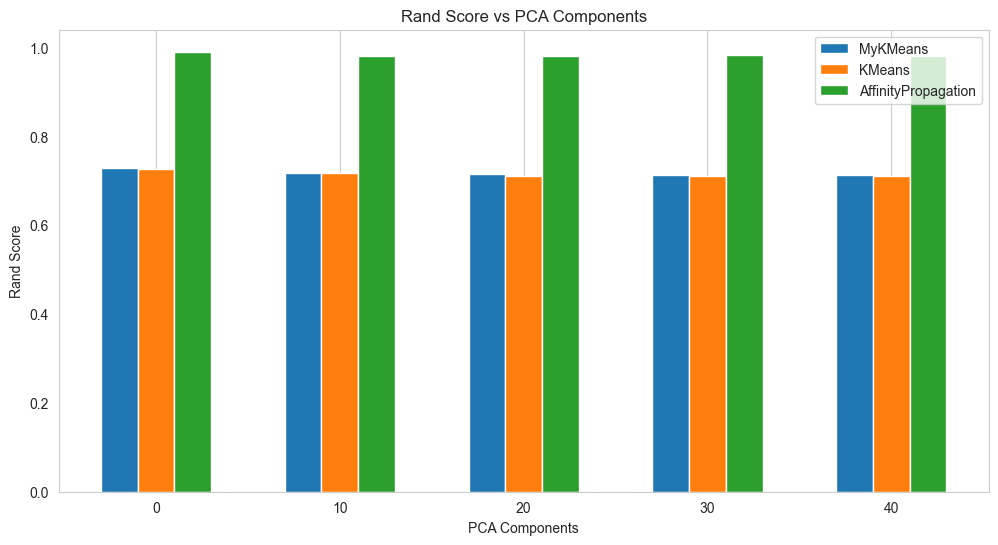

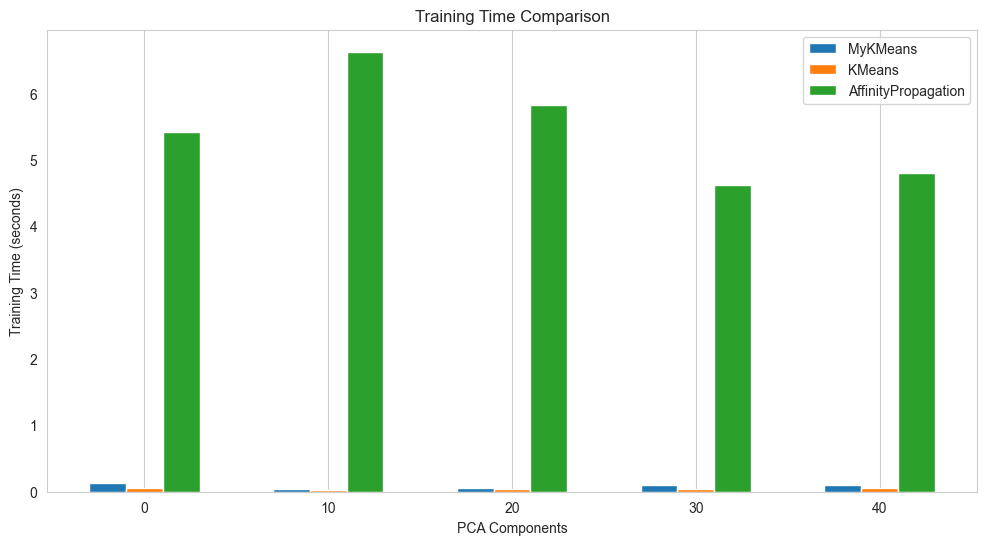

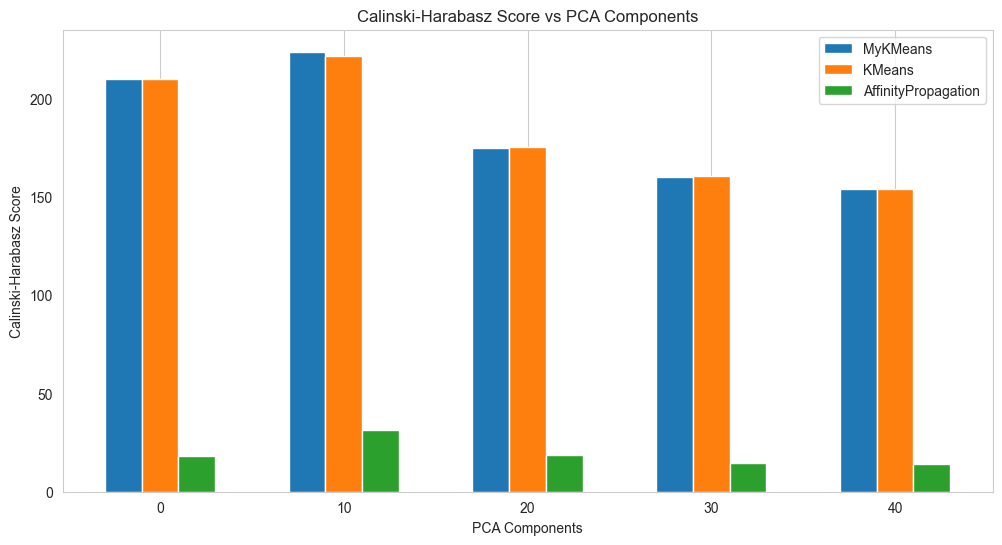

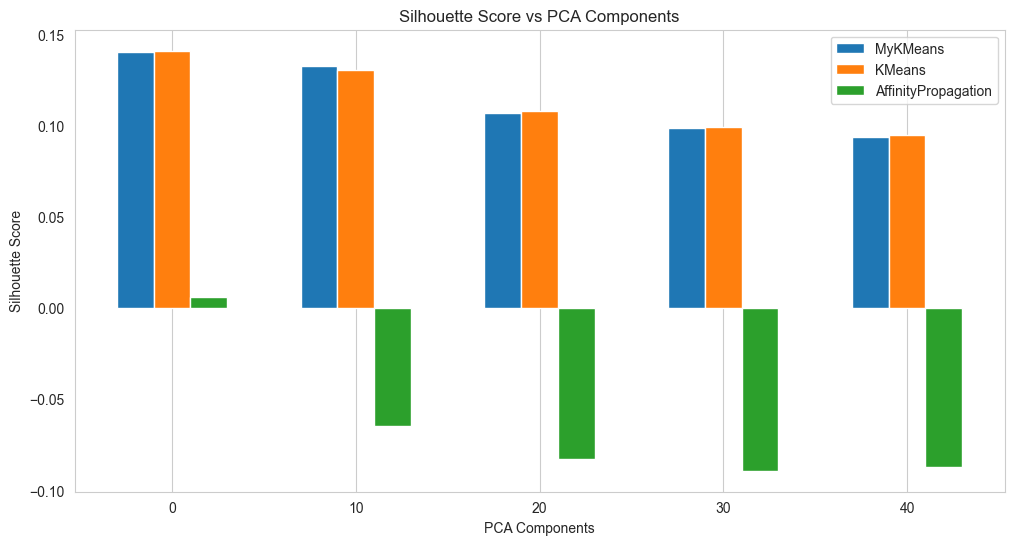

In [316]:
y = df["Name"]
X = df.drop(["Name"], axis=1)

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_list = ['MyKMeans', 'KMeans', 'AffinityPropagation']
pca_variants = [0, 10, 20, 30, 40, 50]
metrics = {model: {'rand': [], 'train_time': [], 'calinski_harabasz': [], 'silhouette': []} for model in models_list}

model_factory = {
    'MyKMeans': lambda: MyKMeans(n_clusters=5, **best_MyKMeans_params),
    'KMeans': lambda: KMeans(n_clusters=5, **best_KMeans_params),
    'AffinityPropagation': lambda: AffinityPropagation(**best_Affinity_params)
}

for n_components in pca_variants:
    transformed_data = PCA(n_components=n_components).fit_transform(X_train_scaled) if n_components != 0 else X_train_scaled
    transformed_data_test = PCA(n_components=n_components).fit_transform(X_test_scaled) if n_components != 0 else X_test_scaled

    for model_name in models_list:
        start = datetime.now()
        model = model_factory[model_name]().fit(transformed_data)
        elapsed_time = (datetime.now() - start).total_seconds()

        predicted_labels = model.predict(transformed_data_test)

        metrics[model_name]['rand'].append(rand_score(y_test, predicted_labels))
        metrics[model_name]['train_time'].append(elapsed_time)
        metrics[model_name]['calinski_harabasz'].append(calinski_harabasz_score(transformed_data_test, predicted_labels))
        metrics[model_name]['silhouette'].append(silhouette_score(transformed_data_test, predicted_labels))

def plot_metric(metric_key, ylabel, title):
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x_positions = np.arange(len(pca_variants))

    for index, model_name in enumerate(models_list):
        plt.bar(x_positions + index * bar_width, metrics[model_name][metric_key], width=bar_width, label=model_name)

    plt.xlabel('PCA Components')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x_positions + bar_width, pca_variants)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

plot_metric('rand', 'Rand Score', 'Rand Score vs PCA Components')
plot_metric('train_time', 'Training Time (seconds)', 'Training Time Comparison')
plot_metric('calinski_harabasz', 'Calinski-Harabasz Score', 'Calinski-Harabasz Score vs PCA Components')
plot_metric('silhouette', 'Silhouette Score', 'Silhouette Score vs PCA Components')

## Вывод

Были протестированы алгоритмы Affinity, KMeans и MyKMeans. Был использован PCA для сокращения размерности. Также были подобраны оптимальные гиперпараметры для каждой модели.

Две реализации KMeans крайне близки друг к другу, в пределах погрешности, поэтому имеет смысл сравнить их с Affinity. Affinity показывает себя лучше всего по версии rand score, однако время обучения и остальные метрики оставляют желать лучшего